# Results Analysis


12/07/2020: Looking at the most recent test results.

We want to specifically look at:

1) False positives/ false negatives - look for patterns in CSNs that were labelled incorrectly by models.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Data

Load in the predicted labels.

In [2]:
# predicted labels
results_dir = "/home/eulalio/BMI212/2019_data/ProjectTriage/"
results_24hr_max_file = "lightgbm_test_results_24hr_max.csv"
results_24hr_recent_file = "lightgbm_test_results_24hr_recent.csv"

results_24hr_max = pd.read_csv(results_dir + results_24hr_max_file)
results_24hr_recent = pd.read_csv(results_dir + results_24hr_recent_file)

In [3]:
# number of unique CSNs in the test set
results_24hr_max.pat_enc_csn_id_coded.nunique()

10096

# Select false positives and false negatives

For each label, take the top 10% of cases where the prediction does not match the actual labels.

In [4]:
results_24hr_max.head()

# filter by true label
# look at true positive cases, sort by predicted probabilities
true_pos = results_24hr_max[results_24hr_max.label_max24 == 1]
true_pos = true_pos.sort_values(by='predictions')

# look at true negative cases
true_neg = results_24hr_max[results_24hr_max.label_max24 == 0]
true_neg = true_neg.sort_values(by='predictions')

true_pos

,Unnamed: 0,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,label,predictions
667,667,JCe6d7d9,131262496618,33932470,1,2019-02-20 05:19:00+00:00,1.0,1,1.0,1,1,0,0,0,1,0.009912
5346,5346,JCcfe02f,131272139062,39040744,1,2019-07-26 03:48:00+00:00,0.0,0,1.0,1,0,0,0,0,1,0.010819
1403,1403,JC2a0a29c,131263702077,34359218,1,2019-01-28 03:17:00+00:00,0.0,0,0.0,1,0,0,0,0,1,0.012352
205,205,JCd870d6,131261590776,33628238,1,2019-01-29 22:38:00+00:00,0.0,1,1.0,1,0,0,1,0,1,0.014303
3837,3837,JCd52cf8,131267599979,36794369,1,2019-05-03 05:38:00+00:00,0.0,1,0.0,1,0,0,1,0,1,0.016127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3814,3814,JC2a26af5,131267538662,36753709,1,2019-05-19 08:00:00+00:00,1.0,1,1.0,1,1,0,0,0,1,0.951682
5728,5728,JCd5aec6,131272844199,39469084,1,2019-07-20 07:03:00+00:00,1.0,1,1.0,1,1,0,0,0,1,0.953073
145,145,JCd8a1f0,131261442227,33576391,1,2019-01-11 22:47:00+00:00,1.0,0,0.0,1,1,0,0,1,1,0.954888
9549,9549,JC2a30edc,131280358490,44242274,1,2019-11-27 01:45:00+00:00,NaN,1,1.0,0,1,0 days 01:04:00,0,0,1,0.967928


In [5]:
true_pos.predictions.describe()

count    1520.000000
mean        0.412408
std         0.272271
min         0.009912
25%         0.161741
50%         0.379480
75%         0.639875
max         0.970786
Name: predictions, dtype: float64

In [6]:
true_neg.predictions.describe()

count    8576.000000
mean        0.090585
std         0.120343
min         0.006218
25%         0.023294
50%         0.042326
75%         0.099450
max         0.940405
Name: predictions, dtype: float64

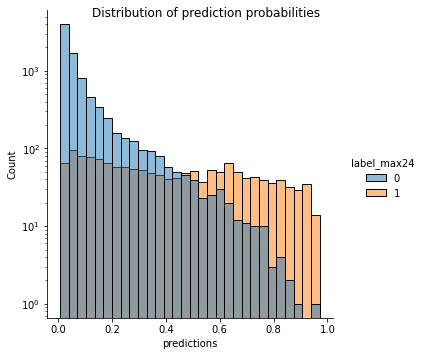

In [7]:
# how do the distributions of predictions compare?
p = sns.displot(results_24hr_max, 
           x='predictions',
           hue='label_max24',
               bins=30)
p.fig.suptitle("Distribution of prediction probabilities")
p.fig.get_axes()[0].set_yscale('log')

plt.show()

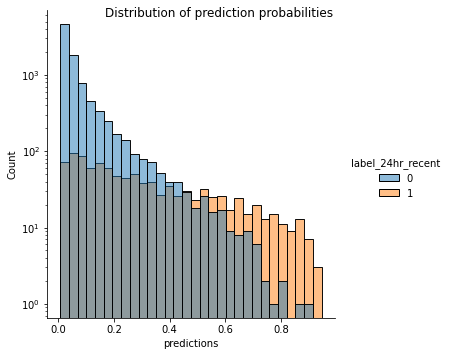

In [8]:
# same for the other labels
p = sns.displot(results_24hr_recent, 
           x='predictions',
           hue='label_24hr_recent',
               bins=30)
p.fig.suptitle("Distribution of prediction probabilities")
p.fig.get_axes()[0].set_yscale('log')

plt.show()

# Length of stay in ED

We want to look at different characteristics of false results, one of them being length of stay in ED. Read in the ADT table to look at this.

In [9]:
# read in the data

adt_file = "/home/eulalio/BMI212/2019_data/triage_cohort_adt_2019.csv"
adt = pd.read_csv(adt_file)

# change the effective time to datetime since read in from csv
adt.effective_time_jittered_utc = pd.to_datetime(adt.effective_time_jittered_utc)

# sort by csn and time
adt.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)

In [10]:
# add the admit time column from the prediction results csv to the adt csv
adt_admit = adt.merge(results_24hr_max, how='left')
adt_admit.head()

adt_admit.admit_time = pd.to_datetime(adt_admit.admit_time)

adt_admit.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'Unnamed: 0',
       'inpatient_data_id_coded', 'label_max24', 'admit_time', 'admit_label',
       'label_24hr_recent', 'label_12hr_recent', 'has_admit_label',
       'first_label', 'first_label_time_since_admit',
       'acute_to_critical_label', 'critical_to_acute_label', 'label',
       'predictions'],
      dtype='object')

In [11]:
# do we still have all of the CSNs? - YES
adt_admit.pat_enc_csn_id_coded.nunique()

52314

In [12]:
# assumes that the data frame is sorted by time!!

# compute the time before admit for each of these events
adt_admit['time_before_admit'] = adt_admit.apply(lambda x: x.admit_time - x.effective_time_jittered_utc, axis=1)
adt_admit.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,label,predictions,time_before_admit
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
2,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [13]:
# mark the events with some labels that make things easier later

# **assumes dataframe is sorted by time

# mark whether previous entry had pat class Emergency Services
adt_admit['prev_emerg'] = adt_admit.pat_class.shift() == 'Emergency Services'
# mark whether current event has pat class Inpatient
adt_admit['curr_inpatient'] = adt_admit.pat_class == 'Inpatient'
# mark whether current event is continued csn as previous
adt_admit['continued'] = adt_admit.pat_enc_csn_id_coded.eq(
    adt_admit.pat_enc_csn_id_coded.shift())

# find our cases by taking the AND of these columns
cols = ['prev_emerg', 'curr_inpatient', 'continued']
adt_admit['first_ip'] = adt_admit[cols].all(axis=1)

adt_admit.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,label,predictions,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,False,False,False,False
1,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,True,False,True,False
2,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:32:00+00:00,2015-01-02 00:32:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,True,False,True,False
3,JCe78a06,131062667066,Emergency Services,NaN,Transfer Out,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,True,False,True,False
4,JCe78a06,131062667066,Emergency Services,NaN,Transfer In,Emergency,NaN,Ward,2015-01-02 00:49:00+00:00,2015-01-02 00:49:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,True,False,True,False


In [14]:
# find the first emergency services pat_class for each csn
change_pat = adt_admit[~adt_admit.pat_class.eq(adt_admit.pat_class.shift())]
change_pat.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,label,predictions,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,False,False,False,False
6,JCe78a06,131062667066,Inpatient,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (PAMF),NaN,Intermediate Intensive Care Unit (IICU-Telemetry),2015-01-02 01:01:00+00:00,2015-01-02 01:02:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,True,True,True,True
20,JCd1c19e,131062745090,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-03 01:56:00+00:00,2015-01-03 01:56:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,False,False,False,False
28,JCd1c19e,131062745090,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,NaN,Private,2015-01-03 05:53:00+00:00,2015-01-03 06:03:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,True,True,True,True
45,JCd91eb2,131062747648,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 01:10:00+00:00,2015-01-01 01:10:00+00:00,...,NaN,NaN,NaN,NaN,NaN,NaT,False,False,False,False


In [15]:
change_pat.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'pat_class', 'pat_lv_of_care',
       'event_type', 'pat_service', 'status_of_bed', 'accomodation',
       'effective_time_jittered_utc', 'event_time_jittered_utc',
       'seq_num_in_enc', 'seq_num_in_bed_min', 'Unnamed: 0',
       'inpatient_data_id_coded', 'label_max24', 'admit_time', 'admit_label',
       'label_24hr_recent', 'label_12hr_recent', 'has_admit_label',
       'first_label', 'first_label_time_since_admit',
       'acute_to_critical_label', 'critical_to_acute_label', 'label',
       'predictions', 'time_before_admit', 'prev_emerg', 'curr_inpatient',
       'continued', 'first_ip'],
      dtype='object')

In [16]:
change_pat.pat_service.value_counts()

Emergency                        58304
General Medicine (University)    13741
Cardiology                        3969
General Medicine (PAMF)           3529
General Surgery                   3253
                                 ...  
Geriatric Psychiatry                 1
Radiology                            1
Pediatric Surgery                    1
Pediatric Nephrology                 1
Immunology                           1
Name: pat_service, Length: 73, dtype: int64

In [17]:
# lots of these still have many events - meaning they moved around a lot
change_pat.groupby('pat_enc_csn_id_coded').anon_id.count().value_counts()

2    50338
3     1243
4      666
5       52
6       10
8        3
1        2
Name: anon_id, dtype: int64

In [18]:
# keep the event with pat_class == Emergency Services, that occurs before the first inpatient event
# check to make sure that we're looking at the same CSN between both events
# don't take any where admit ocurred before ER event - happens when people move around a lot (ER -> Inpatient -> ER -> Inpatient)
keep_visits = change_pat[(change_pat.pat_class == 'Emergency Services') & 
                         (change_pat.shift(-1).first_ip) &
                         (change_pat.shift(-1).pat_enc_csn_id_coded == change_pat.pat_enc_csn_id_coded) & 
                         (change_pat.time_before_admit >= timedelta(days=0))] # remove this for now
keep_visits.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,label,predictions,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip
728123,JCe3a0de,131260430594,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-01 02:47:00+00:00,2019-01-01 02:47:00+00:00,...,0,0.0,0.0,0.0,0.126939,0 days 06:32:00,False,False,False,False
729085,JCde6879,131260494741,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-01 20:37:00+00:00,2019-01-01 20:37:00+00:00,...,0,0.0,0.0,0.0,0.225225,0 days 03:07:00,False,False,False,False
731034,JCe039f4,131260628973,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-01 04:07:00+00:00,2019-01-01 04:07:00+00:00,...,0,0.0,0.0,0.0,0.258251,0 days 04:07:00,False,False,False,False
731171,JCe0ef14,131260654663,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-05 19:36:00+00:00,2019-01-05 19:36:00+00:00,...,0,0.0,0.0,1.0,0.594023,0 days 03:18:00,False,False,False,False
731256,JCe8c709,131260660815,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2018-12-31 21:24:00+00:00,2018-12-31 21:24:00+00:00,...,0,0.0,0.0,0.0,0.340510,0 days 07:42:00,False,False,False,False


In [19]:
# look at the number of csn's that were dropped becuase admit time was before first ER event
print(change_pat.pat_enc_csn_id_coded.nunique())

print(keep_visits.pat_enc_csn_id_coded.nunique())

# we lose about 50 csns where admit occurs before the first ER

52314
10042


In [20]:
# compute the time lapse between the ER visit and admission in hours
keep_visits['hours_before_admit'] = keep_visits.time_before_admit / np.timedelta64(1, 'h')
keep_visits.head()

/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,acute_to_critical_label,critical_to_acute_label,label,predictions,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit
728123,JCe3a0de,131260430594,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-01 02:47:00+00:00,2019-01-01 02:47:00+00:00,...,0.0,0.0,0.0,0.126939,0 days 06:32:00,False,False,False,False,6.533333
729085,JCde6879,131260494741,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-01 20:37:00+00:00,2019-01-01 20:37:00+00:00,...,0.0,0.0,0.0,0.225225,0 days 03:07:00,False,False,False,False,3.116667
731034,JCe039f4,131260628973,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-01 04:07:00+00:00,2019-01-01 04:07:00+00:00,...,0.0,0.0,0.0,0.258251,0 days 04:07:00,False,False,False,False,4.116667
731171,JCe0ef14,131260654663,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2019-01-05 19:36:00+00:00,2019-01-05 19:36:00+00:00,...,0.0,0.0,1.0,0.594023,0 days 03:18:00,False,False,False,False,3.300000
731256,JCe8c709,131260660815,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2018-12-31 21:24:00+00:00,2018-12-31 21:24:00+00:00,...,0.0,0.0,0.0,0.340510,0 days 07:42:00,False,False,False,False,7.700000


# Now look at time in ED

In [21]:
# print(keep_visits.columns)

print(keep_visits.hours_before_admit.describe())

keep_visits['hours_before_admit_quantile'] = pd.qcut(keep_visits.hours_before_admit, 10)

count    10042.000000
mean         4.000407
std          4.124929
min          0.016667
25%          2.233333
50%          3.300000
75%          4.733333
max         95.100000
Name: hours_before_admit, dtype: float64


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


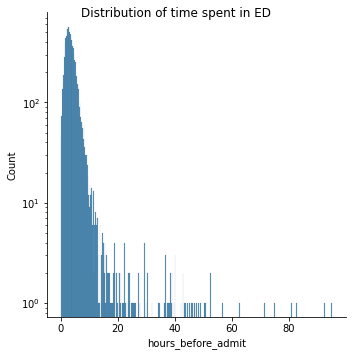

In [22]:
# visualize distribution
p = sns.displot(keep_visits,
               x='hours_before_admit'
               )
p.fig.suptitle("Distribution of time spent in ED")
p.fig.get_axes()[0].set_yscale('log')
plt.show()

## Distribution of predictions based on true labels and time spent in ED

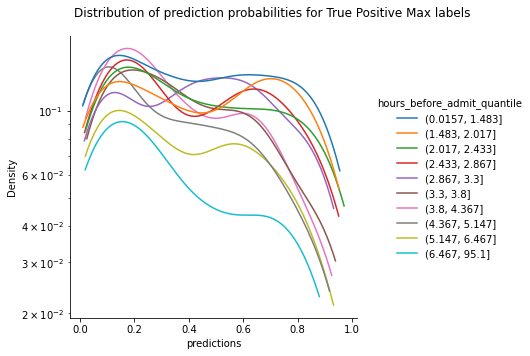

In [23]:
# how do the distributions of predictions compare for true positive cases?
tp_keep_visits = keep_visits[keep_visits.label_max24 == 1]

p = sns.displot(tp_keep_visits, 
           x='predictions',
           hue='hours_before_admit_quantile',
#                bins=30,
#                 col='hours_before_admit_quantile',
#                 col_wrap=5,
                kind='kde',
                cut=0
               )

plt.subplots_adjust(top=0.9)
p.fig.suptitle("Distribution of prediction probabilities for True Positive Max labels")
p.fig.get_axes()[0].set_yscale('log')

plt.show()

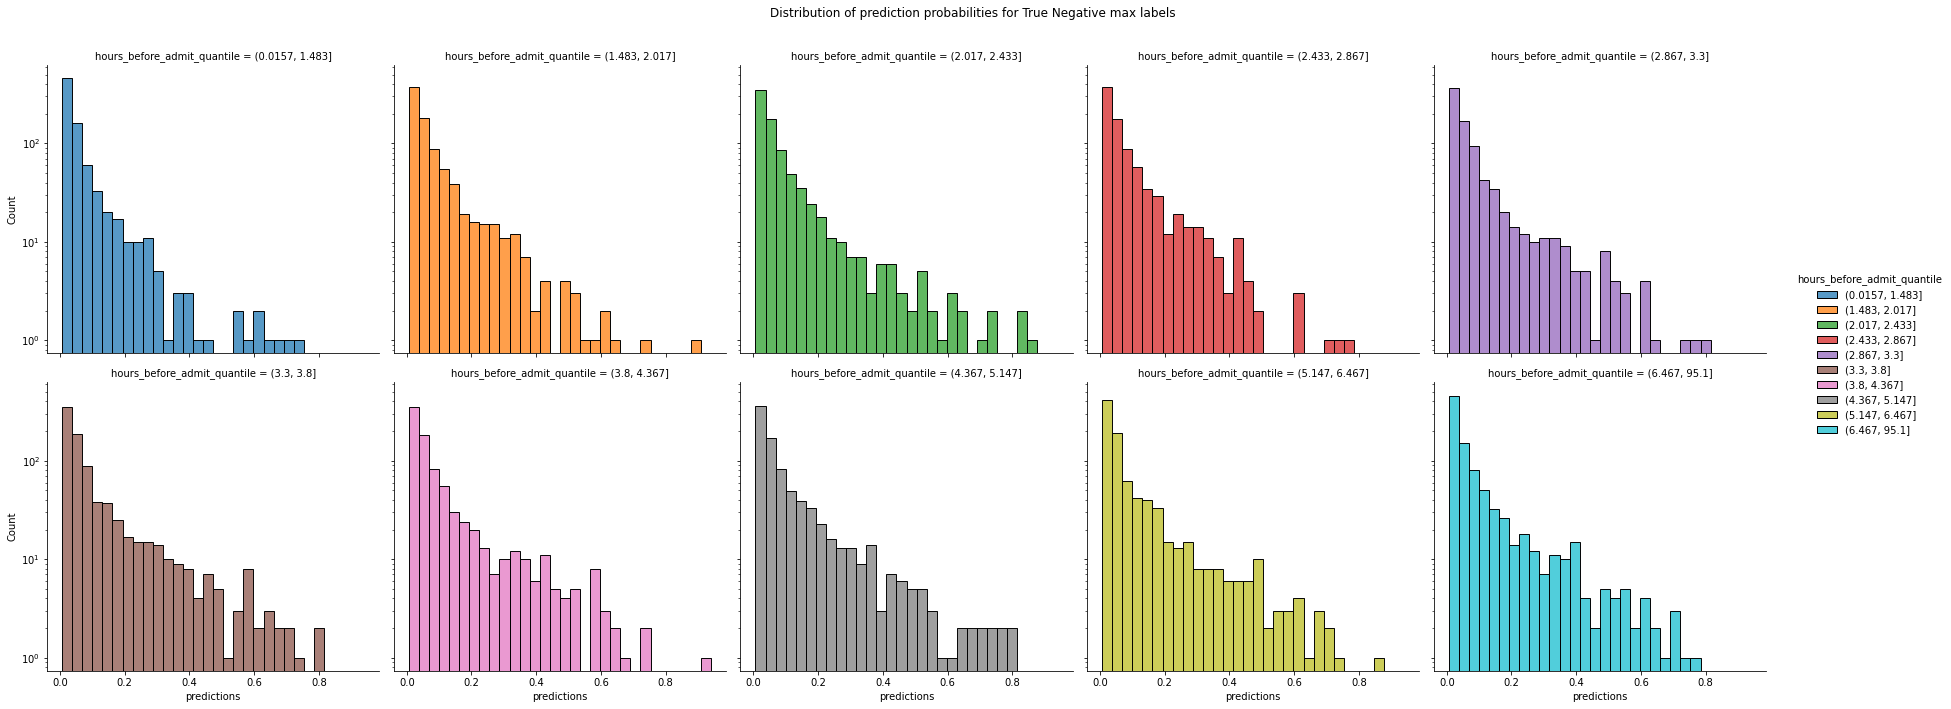

In [24]:
# how do the distributions of predictions compare for true negative cases?
tn_keep_visits = keep_visits[keep_visits.label_max24 == 0]

p = sns.displot(tn_keep_visits, 
           x='predictions',
           hue='hours_before_admit_quantile',
               bins=30,
                col='hours_before_admit_quantile',
                col_wrap = 5
               )

plt.subplots_adjust(top=0.9)
p.fig.suptitle("Distribution of prediction probabilities for True Negative max labels")
p.fig.get_axes()[0].set_yscale('log')

plt.show()

# Missing CSNs

There were about 50 CSNs that had admit time before their ED stay that were excluded from the plots above. Checking on those to see if these are contributing to the false positive and false negative rates.

In [25]:
# what do the 50 csns that were filtered out look lie in terms of probability?
missing_visit_csns = change_pat.pat_enc_csn_id_coded[
    ~change_pat.pat_enc_csn_id_coded.isin(keep_visits.pat_enc_csn_id_coded)]
missing_visits = change_pat[change_pat.pat_enc_csn_id_coded.isin(missing_visit_csns)]

print(change_pat.pat_enc_csn_id_coded.nunique())
print(keep_visits.pat_enc_csn_id_coded.nunique())
print(missing_visits.pat_enc_csn_id_coded.nunique())

# compute the time lapse between the ER visit and admission in hours
missing_visits['hours_before_admit'] = missing_visits.time_before_admit / np.timedelta64(1, 'h')
missing_visits.head()

missing_visits['hours_before_admit_quantile'] = pd.qcut(missing_visits.hours_before_admit, 4)

52314
10042
42272


/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/snap/jupyter/6/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
missing_visits.head()

,anon_id,pat_enc_csn_id_coded,pat_class,pat_lv_of_care,event_type,pat_service,status_of_bed,accomodation,effective_time_jittered_utc,event_time_jittered_utc,...,critical_to_acute_label,label,predictions,time_before_admit,prev_emerg,curr_inpatient,continued,first_ip,hours_before_admit,hours_before_admit_quantile
0,JCe78a06,131062667066,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 17:10:00+00:00,2015-01-01 17:10:00+00:00,...,NaN,NaN,NaN,NaT,False,False,False,False,NaN,NaN
6,JCe78a06,131062667066,Inpatient,Intermediate Care - With Cardiac Monitor,Transfer In,General Medicine (PAMF),NaN,Intermediate Intensive Care Unit (IICU-Telemetry),2015-01-02 01:01:00+00:00,2015-01-02 01:02:00+00:00,...,NaN,NaN,NaN,NaT,True,True,True,True,NaN,NaN
20,JCd1c19e,131062745090,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-03 01:56:00+00:00,2015-01-03 01:56:00+00:00,...,NaN,NaN,NaN,NaT,False,False,False,False,NaN,NaN
28,JCd1c19e,131062745090,Inpatient,Acute Care (Assessment or intervention q4-8),Transfer In,Orthopaedic Surgery,NaN,Private,2015-01-03 05:53:00+00:00,2015-01-03 06:03:00+00:00,...,NaN,NaN,NaN,NaT,True,True,True,True,NaN,NaN
45,JCd91eb2,131062747648,Emergency Services,NaN,Admission,Emergency,NaN,Ward,2015-01-01 01:10:00+00:00,2015-01-01 01:10:00+00:00,...,NaN,NaN,NaN,NaT,False,False,False,False,NaN,NaN


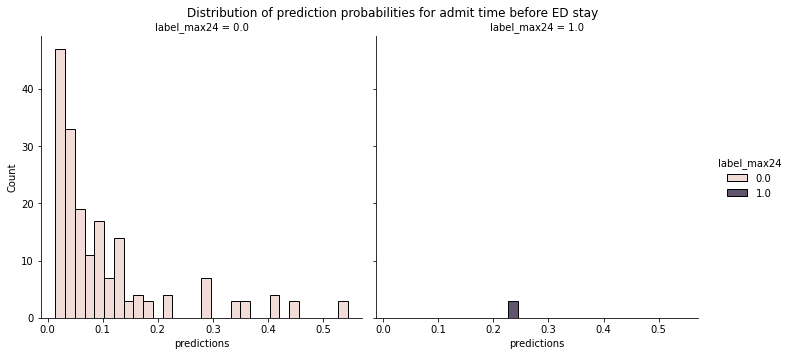

In [27]:
# how do the distributions of predictions compare? This is not so bad. Should be fine to ignore these.
p = sns.displot(missing_visits, 
           x='predictions',
           hue='label_max24',
               bins=30,
               col='label_max24')
p.fig.suptitle("Distribution of prediction probabilities")
# p.fig.get_axes()[0].set_yscale('log')
plt.subplots_adjust(top=0.9)
p.fig.suptitle("Distribution of prediction probabilities for admit time before ED stay")


plt.show()

# Demographics

Bring in additional info to characterise the false predictions.

In [28]:
demo_file = "/home/eulalio/BMI212/2019_data/SHCcore_Data/cohort_demo_final.csv"

demo = pd.read_csv(demo_file)
demo.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,label_max24,admit_time,ESI_i,delta_ESI,gender,age,medis,...,RR,SpO2,Temp,race.Asian,race.Black,race.Native.American,race.Other,race.Pacific.Islander,race.Unknown,race.White
0,JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00,3,0,1,52,0,...,20,99,36.95,0,0,0,0,0,0,1
1,JC29f8ad3,131278291027,42992239,0,2019-10-05 23:48:00,3,0,1,35,0,...,18,99,36.85,1,0,0,0,0,0,0
2,JC29f8b9c,131266787806,36261582,0,2019-05-05 01:07:00,2,0,0,59,1,...,26,74,39.20,0,0,0,0,0,1,0
3,JC29f8beb,131264387263,34626013,0,2019-03-15 03:35:00,3,0,1,30,0,...,16,98,37.05,0,0,0,0,0,0,1
4,JC29f8beb,131279241689,43527040,0,2019-11-27 15:29:00,3,0,1,30,0,...,18,99,37.05,0,0,0,0,0,0,1


In [29]:
demo.columns

Index(['anon_id', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded',
       'label_max24', 'admit_time', 'ESI_i', 'delta_ESI', 'gender', 'age',
       'medis', 'English', 'Height_i', 'delta_H', 'Weight_i', 'delta_W', 'SBP',
       'DBP', 'Pulse', 'RR', 'SpO2', 'Temp', 'race.Asian', 'race.Black',
       'race.Native.American', 'race.Other', 'race.Pacific.Islander',
       'race.Unknown', 'race.White'],
      dtype='object')

In [30]:
# join the demographics info to the prediction results
results_demo = demo.merge(results_24hr_max, on='pat_enc_csn_id_coded')

print(results_demo.pat_enc_csn_id_coded.nunique())

results_demo.head()

10096


,anon_id_x,pat_enc_csn_id_coded,inpatient_data_id_coded_x,label_max24_x,admit_time_x,ESI_i,delta_ESI,gender,age,medis,...,admit_label,label_24hr_recent,label_12hr_recent,has_admit_label,first_label,first_label_time_since_admit,acute_to_critical_label,critical_to_acute_label,label,predictions
0,JC29f8ad2,131274729058,40679773,0,2019-08-31 12:52:00,3,0,1,52,0,...,0.0,0,0.0,1,0,0,0,0,0,0.306509
1,JC29f8ad3,131278291027,42992239,0,2019-10-05 23:48:00,3,0,1,35,0,...,0.0,0,0.0,1,0,0,0,0,0,0.037157
2,JC29f8b9c,131266787806,36261582,0,2019-05-05 01:07:00,2,0,0,59,1,...,0.0,0,0.0,1,0,0,0,0,0,0.043434
3,JC29f8beb,131264387263,34626013,0,2019-03-15 03:35:00,3,0,1,30,0,...,0.0,0,0.0,1,0,0,0,0,0,0.046868
4,JC29f8beb,131279241689,43527040,0,2019-11-27 15:29:00,3,0,1,30,0,...,0.0,0,0.0,1,0,0,0,0,0,0.071149


In [31]:
results_demo.columns

Index(['anon_id_x', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded_x',
       'label_max24_x', 'admit_time_x', 'ESI_i', 'delta_ESI', 'gender', 'age',
       'medis', 'English', 'Height_i', 'delta_H', 'Weight_i', 'delta_W', 'SBP',
       'DBP', 'Pulse', 'RR', 'SpO2', 'Temp', 'race.Asian', 'race.Black',
       'race.Native.American', 'race.Other', 'race.Pacific.Islander',
       'race.Unknown', 'race.White', 'Unnamed: 0', 'anon_id_y',
       'inpatient_data_id_coded_y', 'label_max24_y', 'admit_time_y',
       'admit_label', 'label_24hr_recent', 'label_12hr_recent',
       'has_admit_label', 'first_label', 'first_label_time_since_admit',
       'acute_to_critical_label', 'critical_to_acute_label', 'label',
       'predictions'],
      dtype='object')

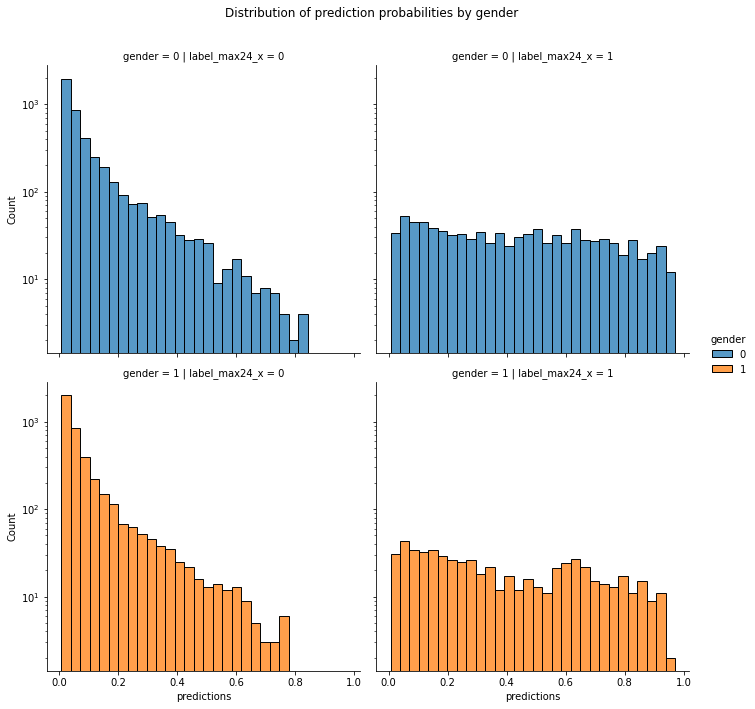

In [32]:
# GENDER
p = sns.displot(results_demo, 
           x='predictions',
           hue='gender',
               bins=30,
               col='label_max24_x',
               row='gender')
p.fig.suptitle("Distribution of prediction probabilities")
p.fig.get_axes()[0].set_yscale('log')
plt.subplots_adjust(top=0.9)
p.fig.suptitle("Distribution of prediction probabilities by gender")


plt.show()

In [33]:
results_demo.columns

Index(['anon_id_x', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded_x',
       'label_max24_x', 'admit_time_x', 'ESI_i', 'delta_ESI', 'gender', 'age',
       'medis', 'English', 'Height_i', 'delta_H', 'Weight_i', 'delta_W', 'SBP',
       'DBP', 'Pulse', 'RR', 'SpO2', 'Temp', 'race.Asian', 'race.Black',
       'race.Native.American', 'race.Other', 'race.Pacific.Islander',
       'race.Unknown', 'race.White', 'Unnamed: 0', 'anon_id_y',
       'inpatient_data_id_coded_y', 'label_max24_y', 'admit_time_y',
       'admit_label', 'label_24hr_recent', 'label_12hr_recent',
       'has_admit_label', 'first_label', 'first_label_time_since_admit',
       'acute_to_critical_label', 'critical_to_acute_label', 'label',
       'predictions'],
      dtype='object')

# Choose a continuous trait and then break into quantiles and plot

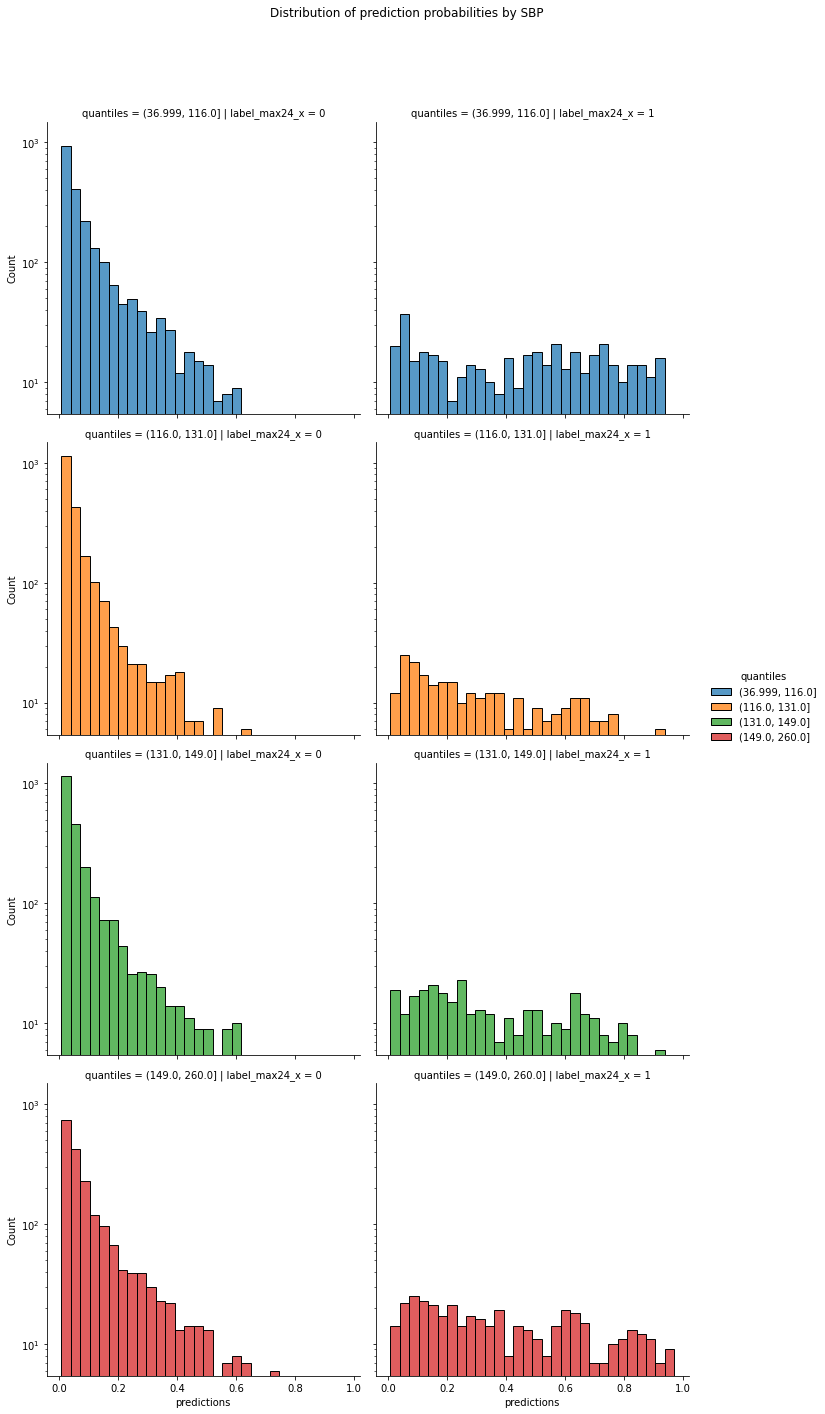

In [34]:
# get quantiles
trait = 'SBP'
results_demo['quantiles'] = pd.qcut(results_demo[trait], 4)

# how do the distributions of predictions compare? This is not so bad. Should be fine to ignore these.
p = sns.displot(results_demo, 
           x='predictions',
           hue='quantiles',
               bins=30,
               col='label_max24_x',
               row='quantiles')
p.fig.get_axes()[0].set_yscale('log')
plt.subplots_adjust(top=0.9)
p.fig.suptitle("Distribution of prediction probabilities by " + trait)


plt.show()

In [35]:
results_demo.columns

Index(['anon_id_x', 'pat_enc_csn_id_coded', 'inpatient_data_id_coded_x',
       'label_max24_x', 'admit_time_x', 'ESI_i', 'delta_ESI', 'gender', 'age',
       'medis', 'English', 'Height_i', 'delta_H', 'Weight_i', 'delta_W', 'SBP',
       'DBP', 'Pulse', 'RR', 'SpO2', 'Temp', 'race.Asian', 'race.Black',
       'race.Native.American', 'race.Other', 'race.Pacific.Islander',
       'race.Unknown', 'race.White', 'Unnamed: 0', 'anon_id_y',
       'inpatient_data_id_coded_y', 'label_max24_y', 'admit_time_y',
       'admit_label', 'label_24hr_recent', 'label_12hr_recent',
       'has_admit_label', 'first_label', 'first_label_time_since_admit',
       'acute_to_critical_label', 'critical_to_acute_label', 'label',
       'predictions', 'quantiles'],
      dtype='object')

# Choose categorical trait and plot

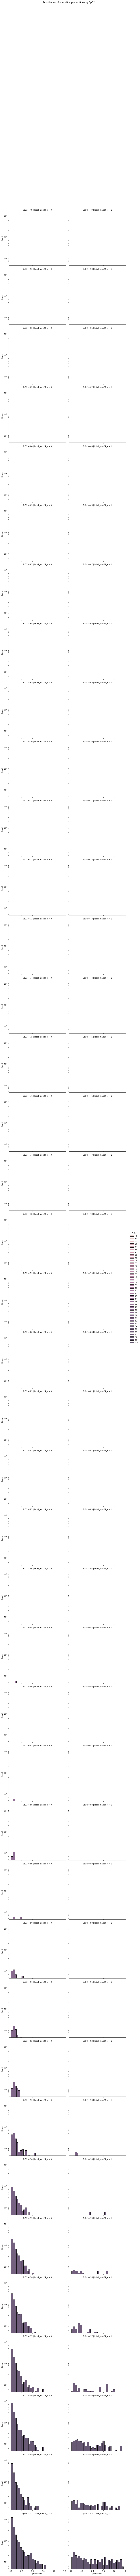

In [36]:
# get quantiles
trait = 'SpO2'

# how do the distributions of predictions compare? This is not so bad. Should be fine to ignore these.
p = sns.displot(results_demo, 
           x='predictions',
           hue=trait,
               bins=30,
               col='label_max24_x',
               row=trait
#                 kind='kde',
#                 cut=0
               )
p.fig.get_axes()[0].set_yscale('log')
plt.subplots_adjust(top=0.9)
p.fig.suptitle("Distribution of prediction probabilities by " + trait)


plt.show()